In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import time 
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GRU, Activation, TimeDistributed, LSTM, BatchNormalization , GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": False})

In [2]:
def plot_samples(generator, image_name, nrows=2, ncols=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    idx = 0

    for i in range(nrows):
        for j in range(ncols):
            label = labels[np.argmax(generator[0][1][idx])]
            ax[i, j].set_title(f"{label}")
            ax[i, j].imshow(generator[0][0][idx][:, :, :])
            ax[i, j].axis("off")
            idx += 1

    plt.tight_layout()
    plt.suptitle("Sample Training Images", fontsize=21)
    
    plt.savefig(image_name + ' - Samples.jpg', dpi=300, format='jpg')
    plt.show()

In [3]:
def plot_history(train_acc, val_acc, train_loss, val_loss, epochs, image_name):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.savefig(image_name + ' - History.jpg', dpi=300, format='jpg')
    plt.show()

In [4]:
def plot_cm(validation_generator, y_pred, image_name):
    labels = validation_generator.class_indices.keys()
    cm = confusion_matrix(validation_generator.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(12, 8))
    disp.plot(cmap=plt.cm.Blues, values_format="d", xticks_rotation='vertical')
    
    plt.savefig(image_name + ' - Confustion Matrix.jpg', dpi=300, format='jpg')
    plt.show()

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
n_classes = 3
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

dataset_path = '/kaggle/input/imageclassification2/train'

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

# EDA

In [6]:
labels = sorted(os.listdir(dataset_path))
class_counts = {} 
sample_images = {} 

for label in labels:
    class_path = os.path.join(dataset_path, label)
    
    images = os.listdir(class_path)
    
    class_counts[label] = len(images)
    
    random_image = random.choice(images)
    sample_images[label] = os.path.join(class_path, random_image)

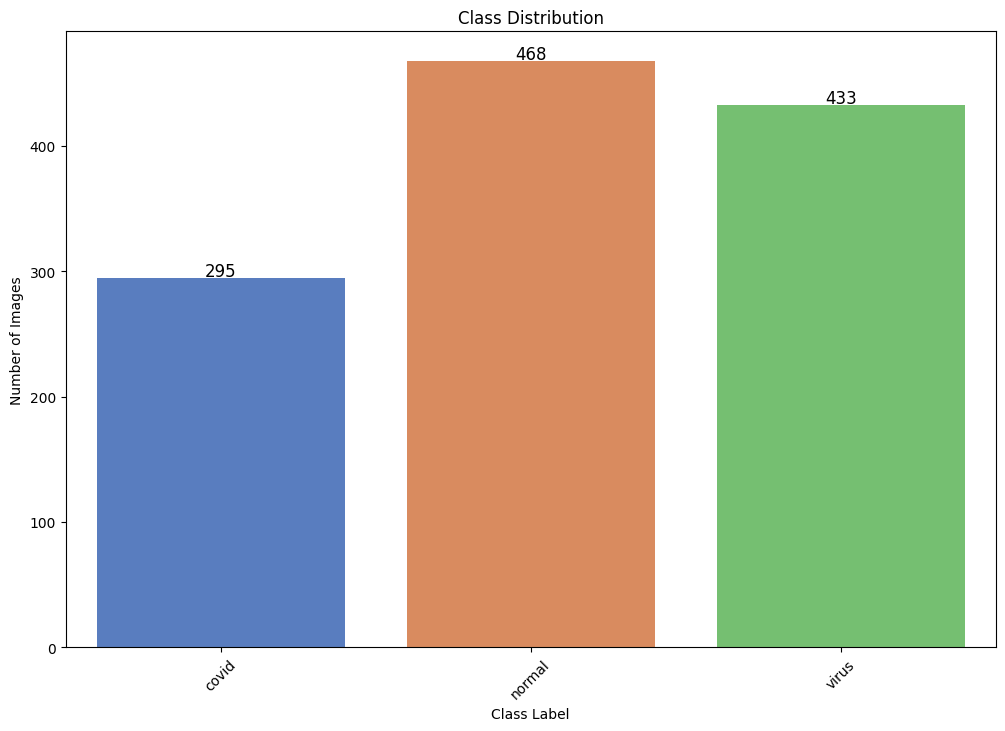

In [7]:
colors = sns.color_palette('muted')

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=colors)

for p, label in zip(ax.patches, class_counts.values()):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, xytext=(0, 5), textcoords='offset points')

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.savefig('Bar - Class Distribution.jpg', dpi=300, format='jpg')
plt.show()

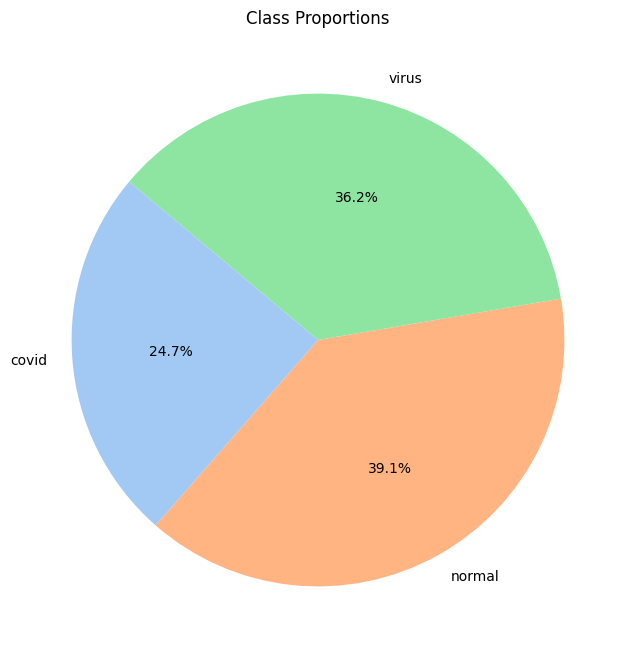

In [8]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Class Proportions')
plt.savefig('Pie - Class Proportions.jpg', dpi=300, format='jpg')
plt.show()

# Modeling

## CNN

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.1, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path, 
    batch_size = 16, 
    subset ='training', 
    class_mode='categorical',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    shuffle = True
)

validation_generator = datagen.flow_from_directory(
    dataset_path, 
    batch_size = 16, 
    subset ='validation', 
    class_mode='categorical',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    shuffle = False
)

Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.


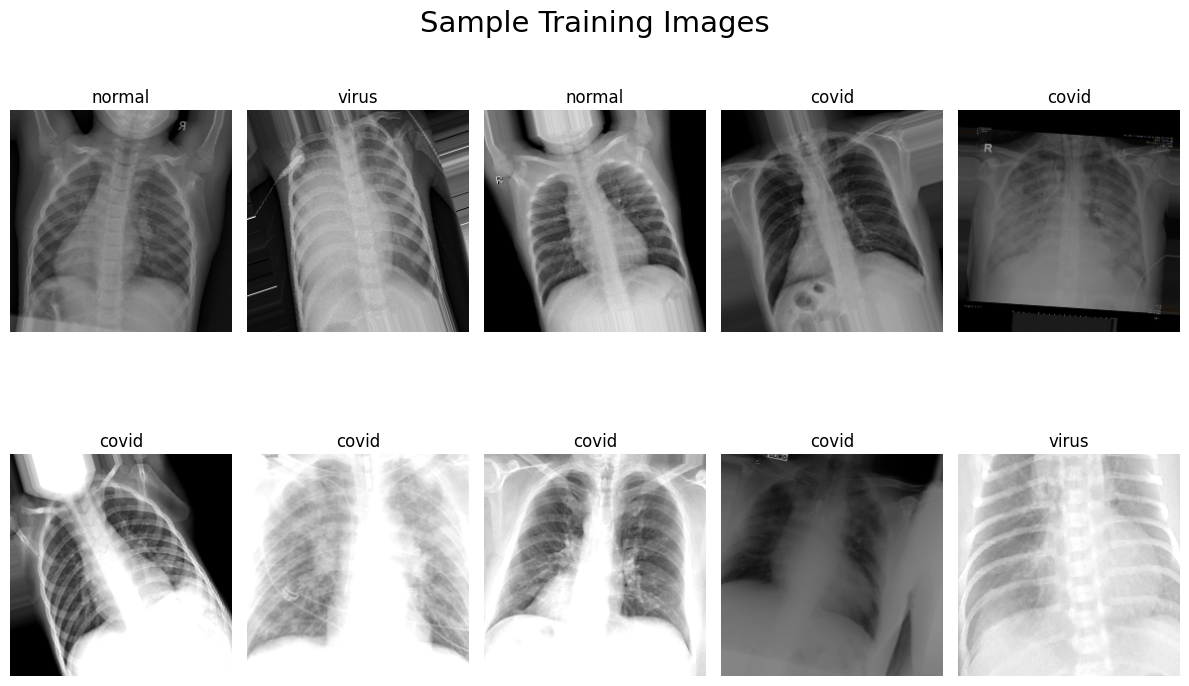

In [10]:
plot_samples(train_generator, "Normal")

In [11]:
model = tf.keras.models.Sequential([
    Conv2D(128, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(265, activation='relu'),
    Dropout(0.3),
    
    Dense(3, activation='softmax')
    ])

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 265)            │       135,945 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           798 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,740,103 (10.45 MB)

 Trainable params: 2,740,039 (10.45 MB)

 Non-trainable params: 64 (256.00 B)

In [14]:
history = model.fit(
    train_generator,
    epochs=30, 
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
 2/60 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.3125 - loss: 1.1026  

I0000 00:00:1711667512.209951     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711667512.228342     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/60 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3884 - loss: 1.7316  

W0000 00:00:1711667533.815463     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4719 - loss: 1.4291

W0000 00:00:1711667552.667254     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 802ms/step - accuracy: 0.4733 - loss: 1.4251 - val_accuracy: 0.4580 - val_loss: 0.9002 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1711667559.581515     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - accuracy: 0.6432 - loss: 0.8793 - val_accuracy: 0.5294 - val_loss: 1.1899 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step - accuracy: 0.7396 - loss: 0.7608 - val_accuracy: 0.5588 - val_loss: 1.1234 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step - accuracy: 0.7501 - loss: 0.6405 - val_accuracy: 0.6639 - val_loss: 0.7443 - learning_rate: 2.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.7917 - loss: 0.5293 - val_accuracy: 0.7689 - val_loss: 0.6310 - learning_rate: 2.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - accuracy: 0.7920 - loss: 0.5123 - val_accuracy: 0.7269 - val_loss: 0.6063 - learning_rate: 2.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.8261 - loss: 0.4735 - val_accuracy: 0.7647 - val_loss: 0.5646 - learning_rate: 2.0000e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step - accuracy: 0.8547 - los

In [15]:
score = model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.9120 - loss: 0.2787
Test loss: 0.28771665692329407
Test accuracy: 0.8907563090324402


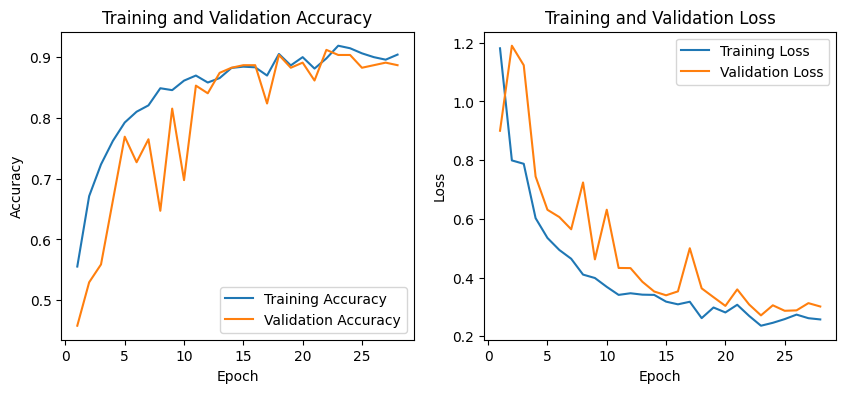

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plot_history(acc, val_acc, loss, val_loss, epochs, "ResNet50")

In [17]:
predict = model.predict(validation_generator)
y_classes = predict.argmax(axis=-1)
y_classes

 1/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step

W0000 00:00:1711668292.440317     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step


W0000 00:00:1711668297.530160     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2,
       2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2])

<Figure size 1200x800 with 0 Axes>

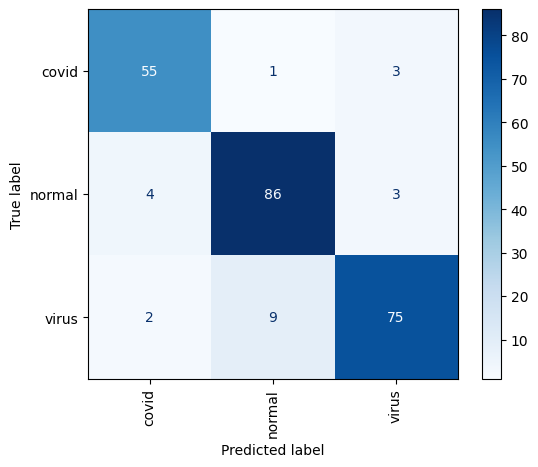

In [18]:
plot_cm(validation_generator, y_classes, "ResNet50")

In [19]:
print(classification_report(validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        59
           1       0.90      0.92      0.91        93
           2       0.93      0.87      0.90        86

    accuracy                           0.91       238
   macro avg       0.91      0.91      0.91       238
weighted avg       0.91      0.91      0.91       238



In [20]:
test_data = pd.read_csv("/kaggle/input/imageclassification2/sample_submission.csv")
predictions = []

for i in test_data["Image"]:
    img = image.load_img("/kaggle/input/imageclassification2/test"+"/"+i, target_size=input_shape)
    X = image.img_to_array(img)/255
    X = np.expand_dims(X, axis = 0)
    images = np.vstack([X])
    val = model.predict(images)
    if np.argmax(val) == 0:
        predictions.append("covid")
    elif np.argmax(val) == 1:
        predictions.append("normal")
    elif np.argmax(val) == 2:
        predictions.append("virus")
    else:
        print("prediction value error!")
        
test_data["Label"] = predictions
test_data.to_csv("model.csv", index = False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

## ResNet50

In [46]:
res_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

res_train_generator = res_datagen.flow_from_directory(
    dataset_path, 
    batch_size=BATCH_SIZE, 
    subset='training', 
    class_mode='categorical',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True
)

res_validation_generator = res_datagen.flow_from_directory(
    dataset_path, 
    subset='validation', 
    class_mode='categorical',
    batch_size = 1, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=False
)

Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.


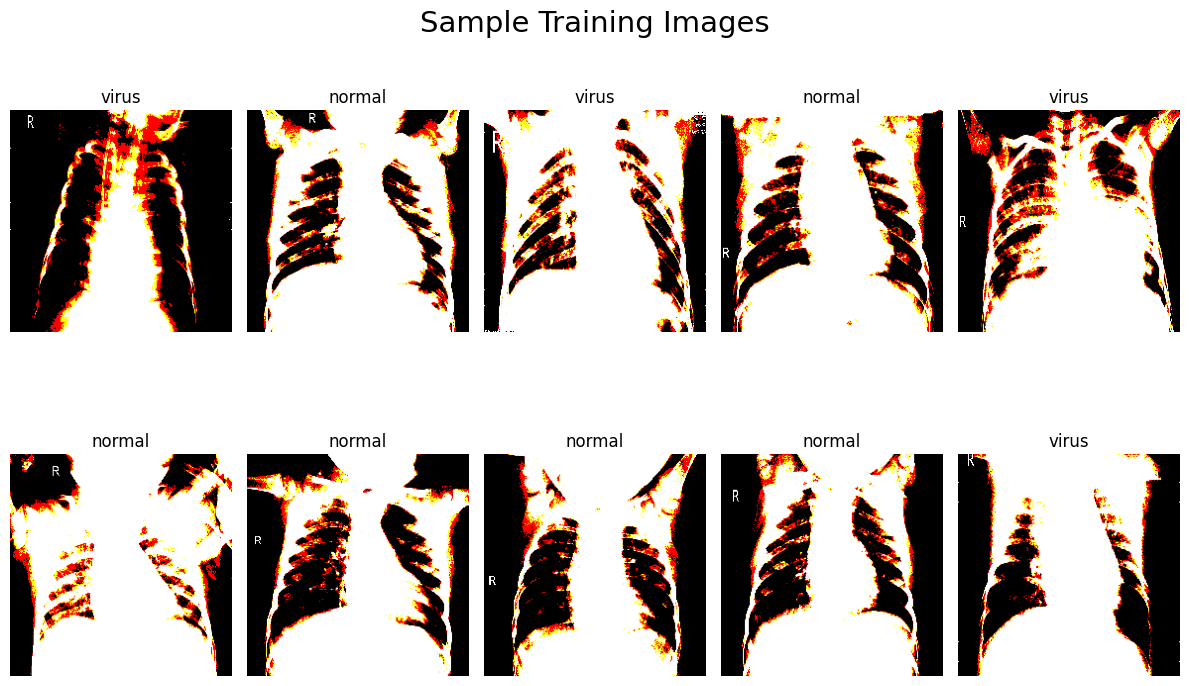

In [47]:
plot_samples(res_train_generator, "ResNet50")

In [59]:
from tensorflow.keras.applications.resnet import ResNet50

resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet50.layers:
    layer.trainable = False

resnet_model = Sequential([
    resnet50,
    
    GlobalAveragePooling2D(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    
    Dense(n_classes, activation='softmax')
])

In [60]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
resnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [63]:
resnet_history = resnet_model.fit(
    res_train_generator,
    epochs=30,
    validation_data=res_validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.6384 - loss: 1.0092 - val_accuracy: 0.9412 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.8990 - loss: 0.3209 - val_accuracy: 0.9244 - val_loss: 0.2202 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.9285 - loss: 0.2099 - val_accuracy: 0.9202 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.9166 - loss: 0.2291 - val_accuracy: 0.9370 - val_loss: 0.1758 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.9409 - loss: 0.1396 - val_accuracy: 0.9496 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.9451 - loss: 0.1539 - val_accuracy: 0.9496 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.9621 - loss: 0.

In [71]:
score = resnet_model.evaluate(res_validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9752 - loss: 0.0631
Test loss: 0.12630940973758698
Test accuracy: 0.9621848464012146


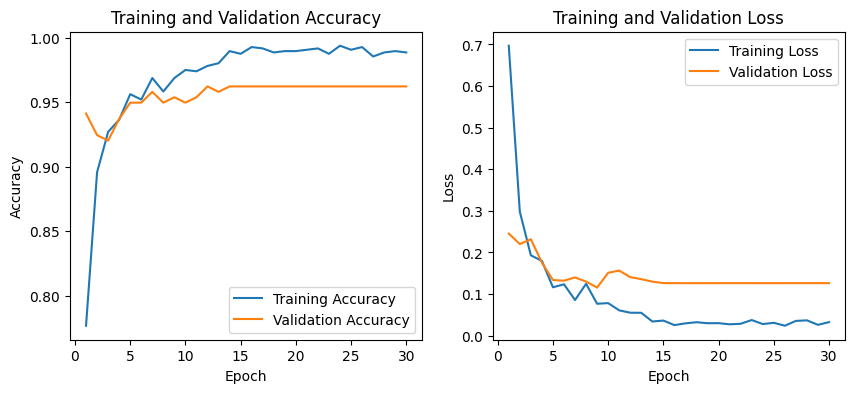

In [65]:
acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']
loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plot_history(acc, val_acc, loss, val_loss, epochs, "ResNet50")

In [72]:
predict = resnet_model.predict(res_validation_generator)
y_classes = predict.argmax(axis=-1)
y_classes

238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

<Figure size 1200x800 with 0 Axes>

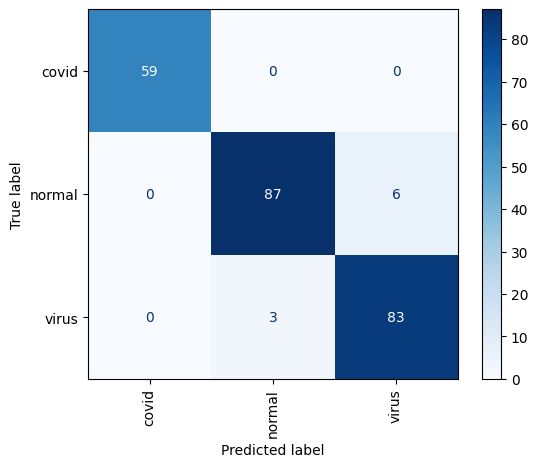

In [73]:
plot_cm(res_validation_generator, y_classes, "ResNet50")

In [74]:
print(classification_report(res_validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       0.97      0.94      0.95        93
           2       0.93      0.97      0.95        86

    accuracy                           0.96       238
   macro avg       0.97      0.97      0.97       238
weighted avg       0.96      0.96      0.96       238



In [69]:
res_test_data = pd.read_csv("/kaggle/input/imageclassification2/sample_submission.csv")
res_predictions = []

for i in res_test_data["Image"]:
    img = image.load_img("/kaggle/input/imageclassification2/test"+"/"+i, target_size=input_shape)
    X = image.img_to_array(img)
    X = tf.keras.applications.resnet50.preprocess_input(X)
    X = np.expand_dims(X, axis = 0)
    images = np.vstack([X])
    val = resnet_model.predict(images)
    if np.argmax(val) == 0:
        res_predictions.append("covid")
    elif np.argmax(val) == 1:
        res_predictions.append("normal")
    elif np.argmax(val) == 2:
        res_predictions.append("virus")
    else:
        print("prediction value error!")
        
res_test_data["Label"] = res_predictions
res_test_data.to_csv("resnet50.csv", index = False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

# Ensemble

In [ ]:
ensemble_predictions = []

for i in test_data["Image"]:
    img = image.load_img("/kaggle/input/imageclassification2/test" + "/" + i, target_size=input_shape)
    X = image.img_to_array(img) / 255.0
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    #pred_model1 = ANN_model.predict(images)
    pred_model2 = model.predict(images)
    
    resX = image.img_to_array(img)
    resX = tf.keras.applications.resnet50.preprocess_input(resX)
    resX = np.expand_dims(resX, axis = 0)
    resimages = np.vstack([resX])
    pred_model3 = resnet_model.predict(resimages)
    
    avg_predictions = (pred_model2 + pred_model3) / 2
    class_labels = ["covid", "normal", "virus"]
    final_prediction = class_labels[np.argmax(avg_predictions)]
    
    ensemble_predictions.append(final_prediction)
    
test_data["Label"] = ensemble_predictions
test_data.to_csv("ensemble.csv", index = False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━